<a href="https://colab.research.google.com/github/DiwakarBasnet/Style_Transfer/blob/main/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Make tensorflow use GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading libraries and data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

from tensorflow import keras
from keras import optimizers
from keras.optimizers import schedules

import PIL
import cv2

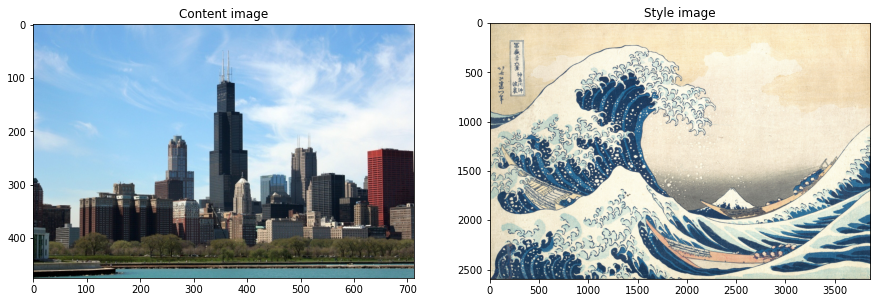

In [3]:
# Load content and style images
content_path = '/content/drive/MyDrive/Images/chicago.jpg'
style_path = '/content/drive/MyDrive/Images/great-wave.jpg'

# read the image file in numpy array
content = plt.imread(content_path)
style = plt.imread(style_path)

# Display the images
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.imshow(content)
ax1.set_title('Content image')
ax2.imshow(style)
ax2.set_title('Style image')
plt.show()

# Cost functions and gram matrix

In [4]:
def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))   # transpose the input tensor 'x' so that the channel dimension(i.e. the number of filters
                                   # or feature maps) comes first. The resulting tensor has dimensions(channels, height, width)

  features = tf.reshape(x, [tf.shape(x)[0], -1])   # reshape the tensor so that each row corresponds to a different feature map, 
                                                 # and each column corresponds to a different spatial location within that feature map.
                                                 # The -1 in the shape argument tells TensorFlow to conclude the number of columns 
                                                 # based on the size of the tensor.

  gram = tf.matmul(features, tf.transpose(features))  # compute the dot product of each pair of rows in the reshaped tensor, 
                                                      # which corresponds to the correlation between different feature maps.
                                                      # The resulting tensor has dimensions (channels, channels).
  
  return gram

In [5]:
def style_cost(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [6]:
def content_cost(content, combination):
  return tf.reduce_sum(tf.square(combination - content)) / 2

# Model

In [7]:
# Loading VGG19 model
from keras.applications import vgg19
from keras.utils import plot_model

model = vgg19.VGG19(weights="imagenet", include_top=False)
model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [8]:
from keras.models import Model

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

# Loss function

In [9]:
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer = "block5_conv2"

content_weight = 2.5e-8
style_weight = 1e-6

def loss_function(combination_image, content_image, style_image):
  # 1. Combine all the images in the same tensor
  input_tensor = tf.concat(
      [content_image, style_image, combination_image],
      axis = 0
  )
  # 2. Get the values in all the layers for the three image
  features = feature_extractor(input_tensor)
  # 3. Initialize the loss
  loss = tf.zeros(shape=())
  # 4. Extract the content layers + content loss
  layer_features = features[content_layer]
  content_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]

  loss = loss + content_weight * content_cost(
      content_image_features, combination_features
  )
  # 5. Extract the style layers + style loss
  for layer_name in style_layers:
    layer_features = features[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_cost(style_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
  
  return loss

We will now write another function which will:
* Calculate the gradients of the loss function we just defined.
* Use these gradients to update the target image.

With GradientTape, we can take advantage of automatic differentiation, which can calculate the gradients of a function based on its composition. We will also use the tf.function decorator to speed up the operations.

When a function is decorated with @tf.function(), Tensorflow will convert the python function into a Tensorflow graph, which can be executed much more efficiently than the original Python code.

In [10]:
@tf.function
def compute_loss_and_grads(combination_image, content_image, style_image):
  with tf.GradientTape() as tape:
    loss = loss_function(combination_image, content_image, style_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

# Image processing and generation

In [11]:
def preprocess_image(image_path):
  # Util function to open, resize and format images into appropriate tensors
  img = keras.preprocessing.image.load_img(
      image_path, target_size=(img_nrows, img_ncols)
  )
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)

In [12]:
# Deprocess image
def deprocess_image(x):
  # Convert tensor to array
  x = x.reshape((img_nrows, img_ncols, 3))
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # Convert BGR to RGB
  x = x[:, :, ::-1]
  # We make sure it is in between 0 and 255
  x = np.clip(x, 0, 255).astype("uint8")
  return x

In [15]:
# Function to generate an image
def show_result(iteration):
  img = deprocess_image(combination_image.numpy())
  img = np.array(img, dtype=np.uint8)
  if np.ndim(img)>3:
    assert img.shape[0] == 1
    img = img[0]
  img = PIL.Image.fromarray(img)
  plt.imshow(np.array(img))
  plt.show()

# Optimization and main code

Iteration 1000: loss=787.93
Iteration 2000: loss=593.36
Iteration 3000: loss=516.21
Iteration 4000: loss=476.50


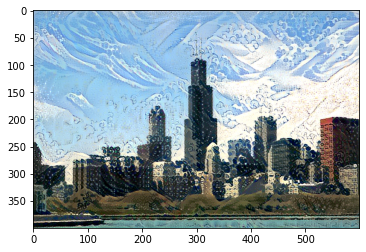

In [16]:
from keras.optimizers import SGD
width, height = tf.keras.utils.load_img(content_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

optimizer = SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

content_image = preprocess_image(content_path)
style_image = preprocess_image(style_path)
combination_image = tf.Variable(preprocess_image(content_path))

iterations = 4000

for i in range(1, iterations + 1):
  loss, grads = compute_loss_and_grads(
      combination_image, content_image, style_image
  )
  grads_and_vars = [(grads, combination_image)]
  optimizer.apply_gradients(grads_and_vars)
  if i % 1000 == 0:
    print("Iteration %d: loss=%.2f" % (i, loss))
  if i == 4000:
    show_result(i)